In [1]:
import numpy as np
from numpy.linalg import cholesky
from numpy.linalg import eigvals
from numpy.linalg import inv
from numpy.linalg import det
from scipy.optimize import minimize

import matplotlib.pyplot as pl
%matplotlib inline

# setup plotting
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [2]:
# defines a block matrix - useful for constructing 4-d correlation matrix 
class block_matrix:
    
    # initialize zero matrix
    def __init__(self, n, m, p, q):
        self.matrix = np.zeros((n*p, m*q))
     
    # set element i, j with matrix a
    def set_element(self, i, j, a):
        p, q = np.shape(a)
        for k in range(p):
            for l in range(q):
                self.matrix[p*i+k, q*j+l] = a[k, l]
    
    # print the matrix nicely
    def __str__(self):
        return_string = ''
        format_string = '{:.2e}'
        m, n = np.shape(self.matrix)
        for i in range(m):
            for j in range(n):
                return_string += format_string.format(self.matrix[i, j]) + ' '
            return_string += '\n'
        return return_string

In [3]:
# TODO: Allow mean to be a function of the input coordinates. 

# defines a gaussian process
class gp:
    
    # initialize with a kernel and mean value (not a function, yet...)
    def __init__(self, mean, kernel1, kernel2=None, wn=1e-6, dim=2):
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.mean = mean
        self.wn = wn
        self.dim = dim
        
        self.computed = False
        self.log_detK = None
        self.x = None
        self.covariance = None
        self.L = None
        self.K_inv = None
            
    # generate the covariance matrix in the 2d case. subcov is the covariance matrix for the second dimension. 
    def _make_covariance_matrix(self, x):
        
        # two dimensional covariance matrix
        if self.dim is 2:
            n = len(x)
            p = len(self.kernel2)
            sigma = block_matrix(n, n, p, p)
            cov1d = np.zeros((n, n))
            
            # define the covariance matrix in the first dimension:
            for i in range(n):
                for j in range(i+1):
                    cov1d[i, j] = self.kernel1(x[i]-x[j])
                    cov1d[j, i] = cov1d[i, j]
                
            for i in range(p):
                for j in range(i+1):
                    if i is j:
                        sigma.set_element(i, j, cov1d*self.kernel2[i, j] + np.diag((self.wn[i]**2.)*np.ones(len(cov1d))))
                    else:
                        sigma.set_element(i, j, cov1d*self.kernel2[i, j])
                        sigma.set_element(j, i, cov1d*self.kernel2[i, j])
                    
            self.covariance = sigma.matrix
            return sigma.matrix
        
        # one dimensional covariance matrix
        elif self.dim is 1:
            n = len(x)
            sigma = np.matrix(np.zeros((n, n)))
            for i in range(n):
                for j in range(i+1):
                    sigma[i, j] = self.kernel1(x[i] - x[j]) + (i == j)*(self.wn**2.)
                    sigma[j, i] = sigma[i, j]
            return sigma
        else: 
            print('bad dimension argument.')
     
    # pre-compute the covariance matrix, its inverse, the cholesky decomposition, etc.
    def compute(self, x):
        if self.x is not x:            
            self.covariance = self._make_covariance_matrix(x)
            self.L = cholesky(self.covariance)
            self.K_inv = inv(self.covariance)
            self.x = x
            
            self.detK = np.prod(np.diag(self.L))**2
            self.log_detK = 2*np.sum(np.diag(self.L))
            
            self.computed = True
    
    # sample the gaussian process in 1 or 2 dimensions. 
    def sample(self, x=None):
        
        if not self.computed:
            if x is not None:
                self.compute(x)
            else:
                print('Covariance matrix has not been computed. Pass in an array of coordinates.')
        elif x is not None:
            self.compute(x)
    
        sigma = self.covariance
        
        if self.dim is 2:
            n_samp = len(self.kernel2)
            n = n_samp*len(self.x)
            u = np.matrix(np.random.randn(n))
            samp = np.array(self.mean*np.ones(n) + (self.L*u.transpose()).transpose())[0]
            ret = []
            for i in range(n_samp):
                ret.append(samp[i*len(self.x):(i+1)*len(self.x)])
            return ret
        elif self.dim is 1:
            n = len(self.x)
            u = np.matrix(np.random.randn(n))
            return np.array(self.mean*np.ones(n) + (self.L*u.transpose()).transpose())[0]
    
    # compute the log-likelihood of the GP model given the data
    def log_likelihood(self, data, x=None):
        
        # make a two-dimensional array of datapoints into the 1-d array corresponding to the gp sample
        def flatten(arr):
            if len(np.shape(arr)) is 1:
                return arr
            else:
                ret = []
                for r in arr:
                    ret = np.concatenate((ret, r))
                return ret
        
        if self.computed is False:
            if x is not None:
                self.compute(x)
            else: 
                print('Covariance matrix has not been computed. Pass in an array of coordinates.')
        
        # see above
        data = flatten(data)
        r = np.matrix((data - self.mean)).transpose()
        
        if self.dim is 1:
            N = len(self.x)  
        elif self.dim is 2:
            n_samp = len(self.kernel2)
            N = n_samp*len(self.x)
        
        # log likelihood computation 
        return -0.5*((r.transpose())*(self.K_inv*r))[0, 0] - 0.5*self.log_detK - 0.5*N*np.log(2*np.pi)
        


# defines the kernel for the gaussian process
class kernel:
    
    # empty init function
    def __init__(self):
        return
     
    # apparently with zero white noise the covariance matrix may not be positive definite...  
    # square exponential kernel with white noise
    def exp_sq_kernel(l, sig, wn=1e-12): 
        def k(r):
            return (sig**2)*np.exp(-(r**2)/(2*(l**2))) + (r == 0)*wn
        return k
    
    def scale_kernel(scale):
        return np.outer(scale, scale)
    
    # white noise adds sigma to diagonal
    def white_noise_kernel(self, white_noise):
        def k(r):
            if r == 0:
                return white_noise
        return k

Text(0,0.5,'flux')

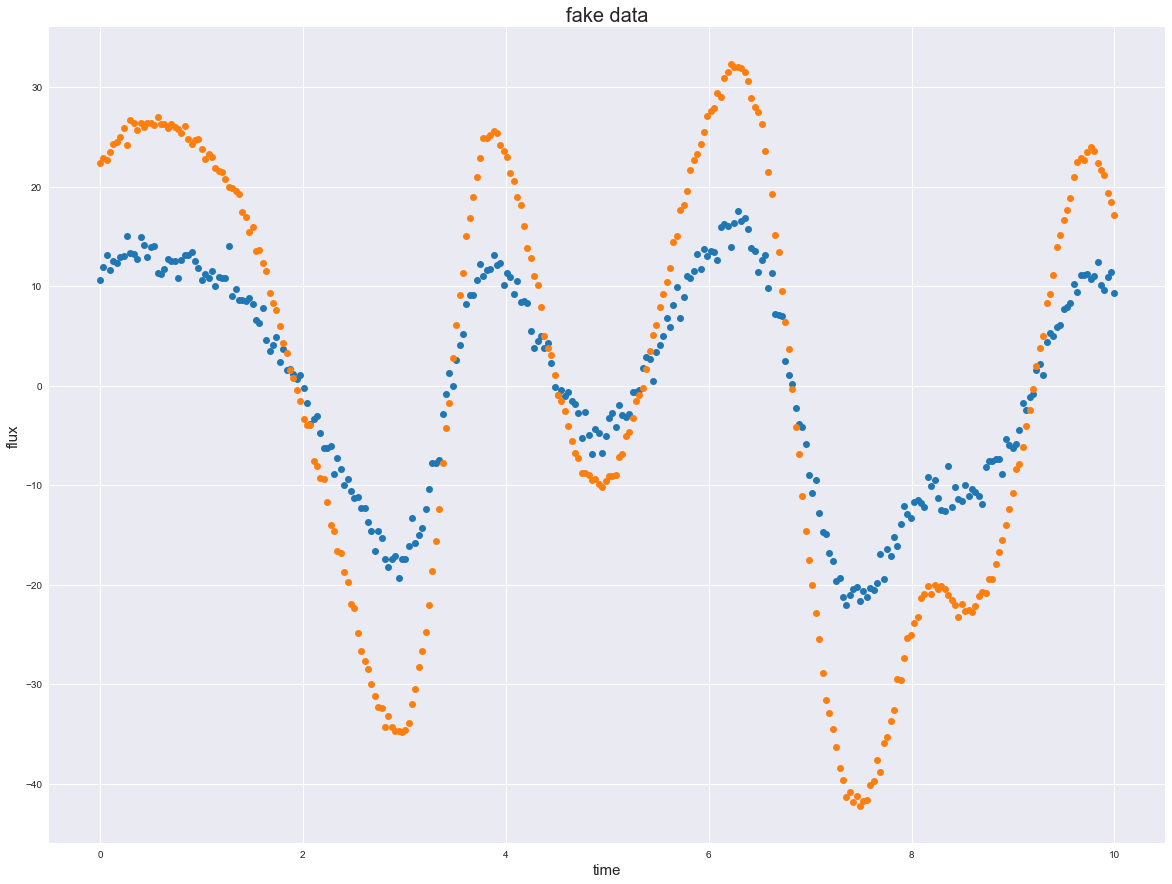

In [12]:
# define the kernel function
k1 = kernel.exp_sq_kernel(0.5, 10)
k2 = kernel.scale_kernel([1, 2])
# initialize the gaussian process with kernel function k and mean of 1
g = gp(0, k1, kernel2=k2, wn=[1, 0.5], dim=2)

# times to sample at
t = np.linspace(0, 10, 300)

# sample the GP to get fake data for fitting
data = g.sample(t)

# plot the data
fig = pl.figure(figsize=(20, 15))
pl.plot(t, data[0], 'o', alpha=1, color=palette[0])
pl.plot(t, data[1], 'o', alpha=1, color=palette[1])


pl.title('fake data', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

best fit mean:  0.16176734250262095
best fit l:  0.5144133212535275
best fit white noise:  0.965386558050192 ,  0.5973659822997544
best fit scale factor:  2.0071320974347304


Text(0,0.5,'flux')

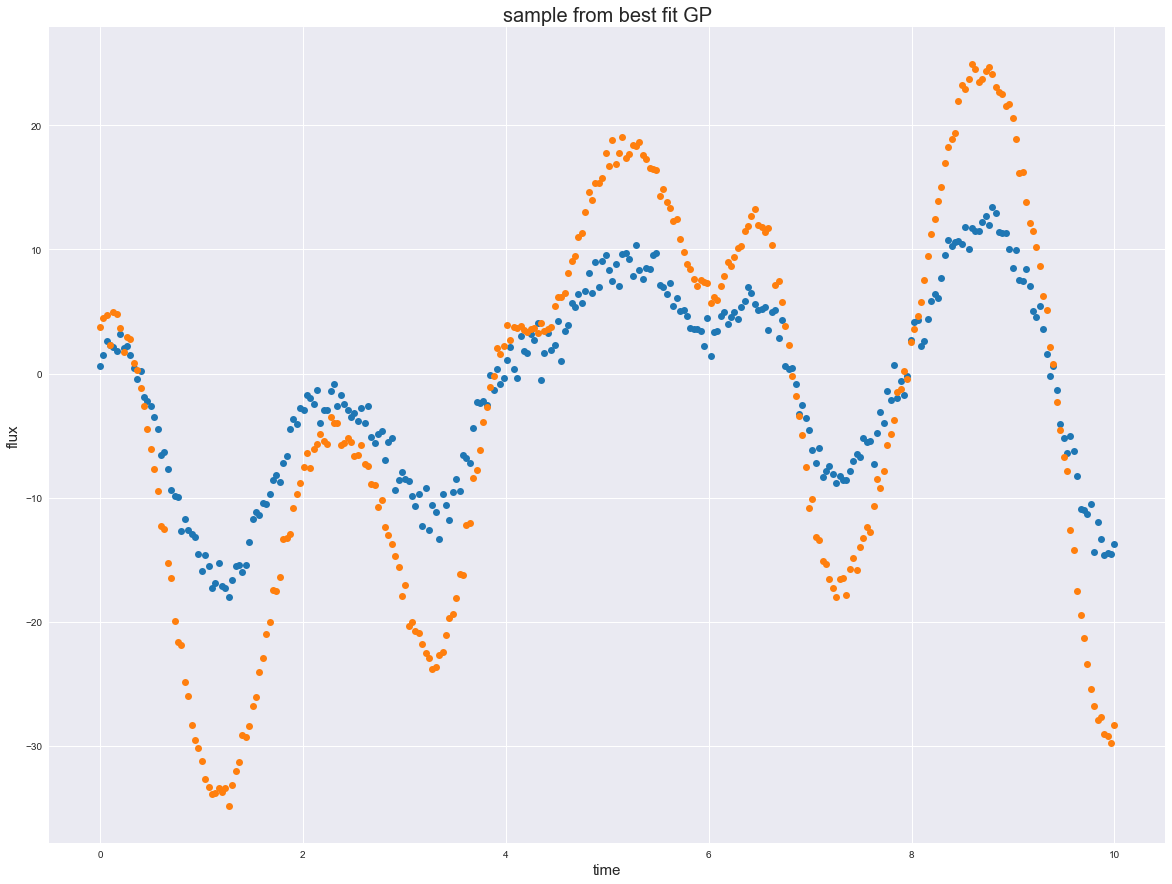

In [13]:
# function to minimize
def neg_log_like(mean, log_l, log_wn1, log_wn2, c, data):
    l, wn1, wn2 = np.exp(np.array([log_l, log_wn1, log_wn2]))
    k1 = kernel.exp_sq_kernel(l, 10)
    k2 = kernel.scale_kernel([1, c])
    g = gp(mean, k1, kernel2=k2, wn=[wn1, wn2], dim=2)
    nll = -g.log_likelihood(data, x=t)
    return nll

func = lambda p: neg_log_like(p[0], p[1], p[2], p[3], p[4], data)

min_params = minimize(func, x0=[-0.5, np.log(0.4), np.log(0.2), np.log(0.2), 1.5], 
                      bounds=[(-np.inf, np.inf), (-np.inf, np.inf), 
                              (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)], method='L-BFGS-B')

l, wn1, wn2 = np.exp([min_params.x[1], min_params.x[2], min_params.x[3]])
mean = min_params.x[0]
c = min_params.x[4]
print('best fit mean: ', mean)
print('best fit l: ', l)
print('best fit white noise: ', wn1, ', ', wn2)
print('best fit scale factor: ', c)

# compute best fit GP
k1 = kernel.exp_sq_kernel(l, 10)
k2 = kernel.scale_kernel([1, c])
g = gp(mean, k1, kernel2=k2, wn=[wn1, wn2], dim=2)
y1, y2 = g.sample(t)

# plot a sample from best fit GP
fig = pl.figure(figsize=(20, 15))
pl.plot(t, y1, 'o', alpha=1, color=palette[0])
pl.plot(t, y2, 'o', alpha=1, color=palette[1])
pl.title('sample from best fit GP', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

In [14]:
import astropy.constants as ac
import batman

def transit_model(params, t):
    p = batman.TransitParams()
    p.t0, p.per, p.rp, p.a, p.inc, p.ecc, p.w, u0, u1 = params
    p.u = [u0, u1]
    p.limb_dark = "quadratic"
    planet = batman.TransitModel(p, t)
    return planet.light_curve(p)

per = 10
t0 = t.min() + (t.max()-t.min())/2. - per
mp_ratio = 0.5
rp = (10*ac.R_earth.value/(ac.R_sun.value))
a = 0.1
a_stellar_rad = a * ac.au.value/(ac.R_sun.value)
inc = 88
ecc = 0
w = 90
u0 = 0.2
u1 = 0.2
planet = transit_model([t0, per, rp, a_stellar_rad, inc, ecc, w, u0, u1], t)

In [17]:
from mygp import gp, kernel
import numpy

# define the kernel function
k1 = kernel.exp_sq_kernel(0.5, 10)
k2 = kernel.scale_kernel([1, 2])
# initialize the gaussian process with kernel function k and mean of 1
g = gp(0, k1, kernel2=k2, wn=[1, 0.5], dim=2)

# times to sample at
t = np.linspace(0, 10, 300)

# sample the GP to get fake data for fitting
data = g.sample(t)

# plot the data
fig = pl.figure(figsize=(20, 15))
pl.plot(t, data[0], 'o', alpha=1, color=palette[0])
pl.plot(t, data[1], 'o', alpha=1, color=palette[1])


pl.title('fake data', size=20)
pl.xlabel('time', size=15)
pl.ylabel('flux', size=15)

NameError: name 'np' is not defined